<a href="https://colab.research.google.com/github/Parkar0707/localrepo/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

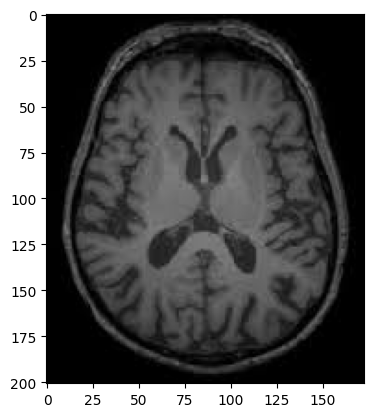

In [2]:
im = Image.open('drive/MyDrive/brain_tumor_dataset_new/train_data/10 no.jpg')
plt.imshow(im, cmap="binary")

In [3]:
im_array = np.array(im)
print('Array Dimensions: ', im_array.shape)
print()
print(im_array)

Array Dimensions:  (201, 173, 3)

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


In [5]:
df_train = pd.read_csv('drive/MyDrive/brain_tumor_dataset_new/train_data.csv')
print(df_train.shape)
df_train.head()

(126, 2)


,label,image
0,1,Y108.jpg
1,1,Y24.jpg
2,1,Y90.jpg
3,0,no 8.jpg
4,1,Y82.jpg


In [6]:
df_valid = pd.read_csv('drive/MyDrive/brain_tumor_dataset_new/valid_data.csv')
print(df_valid.shape)
df_valid.head()

(7, 2)


,label,image
0,1,Y54.jpg
1,0,19 no.jpg
2,1,Y92.jpg
3,0,44no.jpg
4,1,Y187.jpg


In [7]:
df_test = pd.read_csv('drive/MyDrive/brain_tumor_dataset_new/test_data.csv')
print(df_test.shape)
df_test.head()

(26, 2)


,label,image
0,1,Y10.jpg
1,0,25 no.jpg
2,1,Y76.jpg
3,1,Y29.jpg
4,0,no 92.jpg


In [17]:
#************** Helper Dataset **************
import os

class MyDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None, target_size=(300, 240)):
        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['image']
        self.y = df['label']
        self.transform = transform
        self.target_size = target_size

        # Define a transformation to resize images to the target size
        self.resize_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),  # Ensure all images are grayscale
            transforms.Resize(self.target_size),
            transforms.ToTensor()  # Ensure the image is converted to a tensor
        ])

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.img_names[index])
        img = Image.open(img_path).convert('L')  # Ensure all images are grayscale

        # Apply resize and tensor transformation
        img = self.resize_transform(img)

        label = self.y[index]
        return img, label

    def __len__(self):
        return len(self.y)

def get_dataloaders(batch_size,
                    csv_dir='drive/MyDrive/brain_tumor_dataset_new/',
                    img_dir='drive/MyDrive/brain_tumor_dataset_new/',
                    num_workers=0,
                    batch_size_factor_eval=10,
                    train_transforms=None,
                    test_transforms=None):

    if train_transforms is None:
        train_transforms = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((300, 240)),
            transforms.ToTensor()
        ])

    if test_transforms is None:
        test_transforms = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((300, 240)),
            transforms.ToTensor()
        ])

    train_dataset = MyDataset(
        csv_path=os.path.join(csv_dir, 'train_data.csv'),
        img_dir=os.path.join(img_dir, 'train_data'),
        transform=train_transforms)

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        drop_last=True,
        shuffle=True,  # want to shuffle the dataset
        num_workers=num_workers)  # number processes/CPUs to use

    valid_dataset = MyDataset(
        csv_path=os.path.join(csv_dir, 'valid_data.csv'),
        img_dir=os.path.join(img_dir, 'valid_data'),
        transform=test_transforms)

    valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size*batch_size_factor_eval,
        shuffle=False,
        num_workers=num_workers)

    test_dataset = MyDataset(
        csv_path=os.path.join(csv_dir, 'test_data.csv'),
        img_dir=os.path.join(img_dir, 'test_data'),
        transform=test_transforms)

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size*batch_size_factor_eval,
        shuffle=False,
        num_workers=num_workers)

    return train_loader, valid_loader, test_loader

**Functions:**

In [10]:
# ************* Helper Plotting ************
import os
def plot_training_loss(minibatch_loss_list, num_epochs, iter_per_epoch,
                       results_dir=None, averaging_iterations=100):

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_loss_list)),
             (minibatch_loss_list), label='Minibatch Loss')

    if len(minibatch_loss_list) > 1000:
        ax1.set_ylim([
            0, np.max(minibatch_loss_list[1000:])*1.5
            ])
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    ax1.plot(np.convolve(minibatch_loss_list,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label='Running Average')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(results_dir, 'plot_training_loss.pdf')
        plt.savefig(image_path)


def plot_accuracy(train_acc_list, valid_acc_list, results_dir):

    num_epochs = len(train_acc_list)

    plt.plot(np.arange(1, num_epochs+1),
             train_acc_list, label='Training')
    plt.plot(np.arange(1, num_epochs+1),
             valid_acc_list, label='Validation')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(
            results_dir, 'plot_acc_training_validation.pdf')
        plt.savefig(image_path)


def show_examples(model, data_loader):

    for batch_idx, (features, targets) in enumerate(data_loader):

        with torch.no_grad():
            features = features
            targets = targets
            logits = model(features)
            predictions = torch.argmax(logits, dim=1)
        break

    fig, axes = plt.subplots(nrows=3, ncols=5,
                             sharex=True, sharey=True)

    nhwc_img = np.transpose(features, axes=(0, 2, 3, 1))
    nhw_img = np.squeeze(nhwc_img.numpy(), axis=3)

    for idx, ax in enumerate(axes.ravel()):
        ax.imshow(nhw_img[idx], cmap='binary')
        ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
        ax.axison = False

    plt.tight_layout()
    plt.show()

In [11]:
#**************** Helper Evaluation **********
# imports from installed libraries
import os
import random
from distutils.version import LooseVersion as Version


def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    if torch.__version__ <= Version("1.7"):
        torch.set_deterministic(True)
    else:
        torch.use_deterministic_algorithms(True)


def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


In [12]:
# **************** Helper Train ************
import time
#from helper_evaluation import compute_accuracy

def train_model(model, num_epochs, train_loader,
                valid_loader, test_loader, optimizer, device):

    start_time = time.time()
    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)

            # ## FORWARD AND BACK PROP
            logits = model(features)
            loss = torch.nn.functional.cross_entropy(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            # ## UPDATE MODEL PARAMETERS
            optimizer.step()

            # ## LOGGING
            minibatch_loss_list.append(loss.item())
            if not batch_idx % 50:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                      f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                      f'| Loss: {loss:.4f}')

        model.eval()
        with torch.no_grad():  # save memory during inference
            train_acc = compute_accuracy(model, train_loader, device=device)
            valid_acc = compute_accuracy(model, valid_loader, device=device)
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Train: {train_acc :.2f}% '
                  f'| Validation: {valid_acc :.2f}%')
            train_acc_list.append(train_acc.item())
            valid_acc_list.append(valid_acc.item())

        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')

    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')

    test_acc = compute_accuracy(model, test_loader, device=device)
    print(f'Test accuracy {test_acc :.2f}%')

    return minibatch_loss_list, train_acc_list, valid_acc_list

In [56]:
RANDOM_SEED = 1
BATCH_SIZE = 32
NUM_EPOCHS = 100

In [57]:
class MLP(torch.nn.Module):
  def __init__(self, num_features, num_hidden, num_classes):
    super().__init__()

    self.num_classes = num_classes

    self.model = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(num_features, num_hidden),
        torch.nn.Sigmoid(),
        torch.nn.Linear(num_hidden, num_classes)
    )

  def forward(self, x):
    return self.model(x)

torch.manual_seed(RANDOM_SEED)
model = MLP(num_features=300*240, num_hidden=100, num_classes=2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# MyDataset Class

In [58]:
class MyDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None, target_size=(300, 240)):
        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_name = df['image']
        self.y = df['label']
        self.transform = transform
        self.target_size = target_size

        # Define a transformation to resize images to the target size
        self.resize_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),  # Ensure all images are grayscale
            transforms.Resize(self.target_size),
        ])

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.img_name[index])
        img = Image.open(img_path).convert('L')  # Ensure all images are grayscale

        # Apply resize transformation
        img = self.resize_transform(img)

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]
        return img, label

    def __len__(self):
        return len(self.y)

# Data Augmentation

In [59]:
# Data augmentation transformations for the training data
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(60),
    transforms.RandomResizedCrop((300, 240), scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()  # Convert the image to a tensor
])

# Transformations for the validation and test data (only resize and to tensor)
test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure all images are grayscale
    transforms.Resize((300, 240)),
    transforms.ToTensor()
])

# Data Loaders

In [60]:
# Create data loaders
train_dataset = MyDataset(csv_path="drive/MyDrive/brain_tumor_dataset/train_data.csv",
                          img_dir="drive/MyDrive/brain_tumor_dataset/train_data",
                          transform=train_transforms)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=16,
                          drop_last=True,
                          shuffle=True,
                          num_workers=0)

valid_dataset = MyDataset(csv_path="drive/MyDrive/brain_tumor_dataset/valid_data.csv",
                          img_dir="drive/MyDrive/brain_tumor_dataset/valid_data",
                          transform=test_transforms)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=16,
                          shuffle=False,
                          num_workers=0)

test_dataset = MyDataset(csv_path="drive/MyDrive/brain_tumor_dataset/test_data.csv",
                         img_dir="drive/MyDrive/brain_tumor_dataset/test_data",
                         transform=test_transforms)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=16,
                         shuffle=False,
                         num_workers=0)

In [66]:
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):
  for batch_idx, (x, y) in enumerate(train_loader):
    print('Epoch:', epoch+1, end='')
    print(' | Batch index: ', batch_idx, end='')
    print(' | Batch size: ', y.size()[0])

Epoch: 1 | Batch index:  0 | Batch size:  32
Epoch: 1 | Batch index:  1 | Batch size:  32
Epoch: 1 | Batch index:  2 | Batch size:  32
Epoch: 2 | Batch index:  0 | Batch size:  32
Epoch: 2 | Batch index:  1 | Batch size:  32
Epoch: 2 | Batch index:  2 | Batch size:  32


In [36]:
torch.manual_seed(RANDOM_SEED)

# Batch Details

In [51]:
# Print batch details
for images, labels in train_loader:
  print('Image batch dimensions:', images.shape)
  print('Image label dimensions:', labels.shape)
  print('Class labels of 10 Examples:', labels[:10])
  break

Image batch dimensions: torch.Size([16, 1, 300, 240])
Image label dimensions: torch.Size([16])
Class labels of 10 Examples: tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 0])


In [61]:
train_loader, valid_loader, test_loader = get_dataloaders(batch_size=BATCH_SIZE,
                                                          train_transforms=train_transforms,
                                                          test_transforms=test_transforms)


In [62]:
set_all_seeds(RANDOM_SEED)
set_deterministic()

<ipython-input-11-fe2d2e2fcfbc>:23: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if torch.__version__ <= Version("1.7"):


In [63]:
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=None
)

Epoch: 001/100 | Batch 0000/0003 | Loss: 0.6986
Epoch: 001/100 | Train: 54.17% | Validation: 57.14%
Time elapsed: 0.03 min
Epoch: 002/100 | Batch 0000/0003 | Loss: 1.7537
Epoch: 002/100 | Train: 45.83% | Validation: 42.86%
Time elapsed: 0.05 min
Epoch: 003/100 | Batch 0000/0003 | Loss: 0.6825
Epoch: 003/100 | Train: 55.21% | Validation: 57.14%
Time elapsed: 0.08 min
Epoch: 004/100 | Batch 0000/0003 | Loss: 0.6898
Epoch: 004/100 | Train: 67.71% | Validation: 71.43%
Time elapsed: 0.10 min
Epoch: 005/100 | Batch 0000/0003 | Loss: 0.6374
Epoch: 005/100 | Train: 72.92% | Validation: 85.71%
Time elapsed: 0.14 min
Epoch: 006/100 | Batch 0000/0003 | Loss: 0.6485
Epoch: 006/100 | Train: 67.71% | Validation: 85.71%
Time elapsed: 0.17 min
Epoch: 007/100 | Batch 0000/0003 | Loss: 0.6171
Epoch: 007/100 | Train: 59.38% | Validation: 57.14%
Time elapsed: 0.19 min
Epoch: 008/100 | Batch 0000/0003 | Loss: 0.6349
Epoch: 008/100 | Train: 67.71% | Validation: 71.43%
Time elapsed: 0.22 min
Epoch: 009/100 |

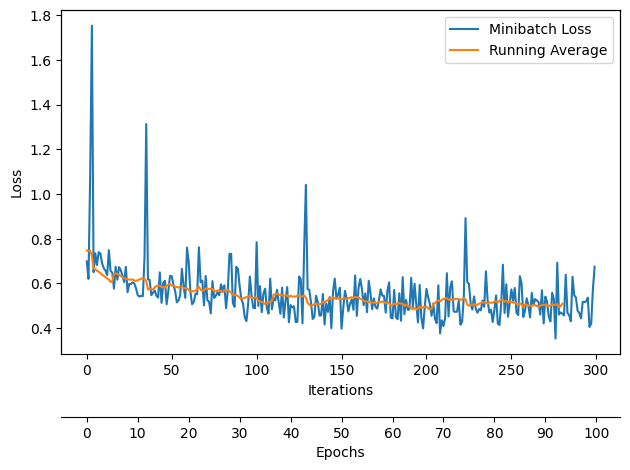

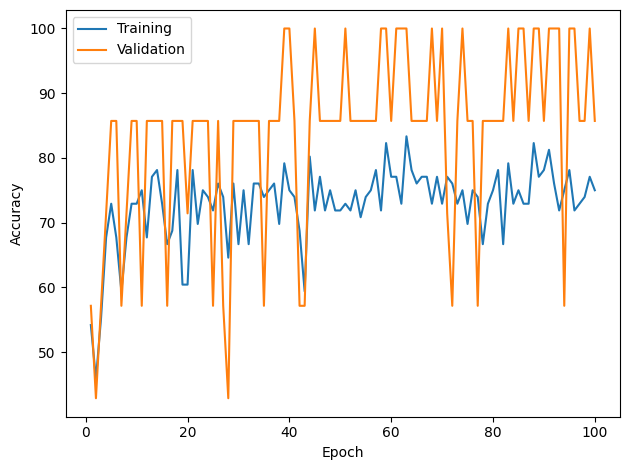

In [64]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)

plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.show()

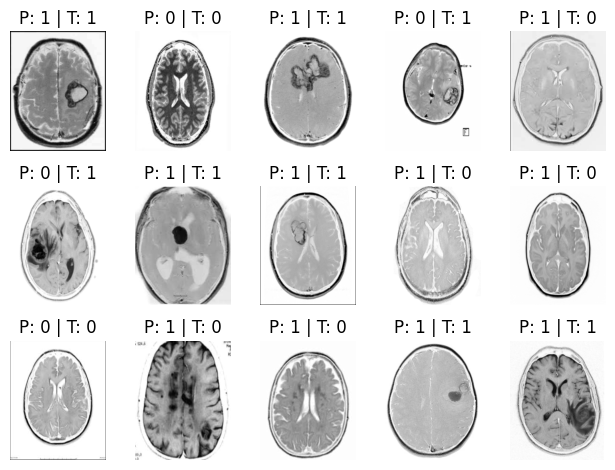

In [65]:
show_examples(model=model, data_loader=test_loader)

Image batch dimensions: torch.Size([16, 1, 300, 240])
Image label dimensions: torch.Size([16])
Class labels of 10 Examples: tensor([1, 1, 0, 0, 0, 1, 1, 1, 0, 0])
Image batch dimensions: torch.Size([16, 1, 300, 240])
Image label dimensions: torch.Size([16])
Class labels of 10 Examples: tensor([0, 1, 1, 1, 1, 0, 1, 0, 0, 0])


<ipython-input-11-fe2d2e2fcfbc>:23: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if torch.__version__ <= Version("1.7"):


Epoch: 001/025 | Batch 0000/0007 | Loss: 0.4543
Epoch: 001/025 | Train: 76.79% | Validation: 100.00%
Time elapsed: 0.03 min
Epoch: 002/025 | Batch 0000/0007 | Loss: 0.5262
Epoch: 002/025 | Train: 77.68% | Validation: 100.00%
Time elapsed: 0.08 min
Epoch: 003/025 | Batch 0000/0007 | Loss: 0.5465
Epoch: 003/025 | Train: 72.32% | Validation: 100.00%
Time elapsed: 0.11 min
Epoch: 004/025 | Batch 0000/0007 | Loss: 0.6808
Epoch: 004/025 | Train: 75.00% | Validation: 100.00%
Time elapsed: 0.15 min
Epoch: 005/025 | Batch 0000/0007 | Loss: 0.3613
Epoch: 005/025 | Train: 78.57% | Validation: 85.71%
Time elapsed: 0.18 min
Epoch: 006/025 | Batch 0000/0007 | Loss: 0.4770
Epoch: 006/025 | Train: 73.21% | Validation: 57.14%
Time elapsed: 0.21 min
Epoch: 007/025 | Batch 0000/0007 | Loss: 0.4733
Epoch: 007/025 | Train: 67.86% | Validation: 85.71%
Time elapsed: 0.24 min
Epoch: 008/025 | Batch 0000/0007 | Loss: 0.4567
Epoch: 008/025 | Train: 73.21% | Validation: 57.14%
Time elapsed: 0.28 min
Epoch: 009/0

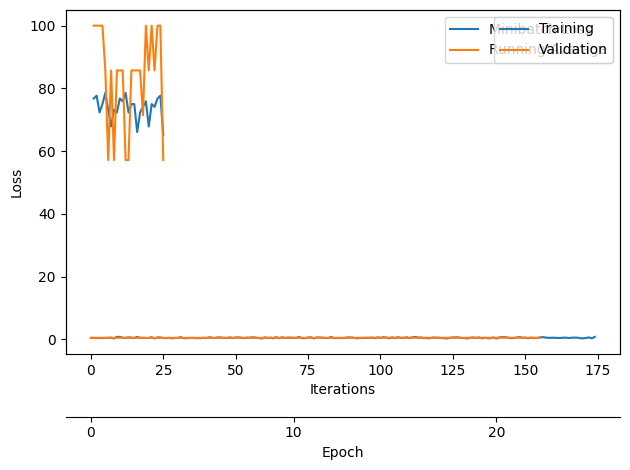

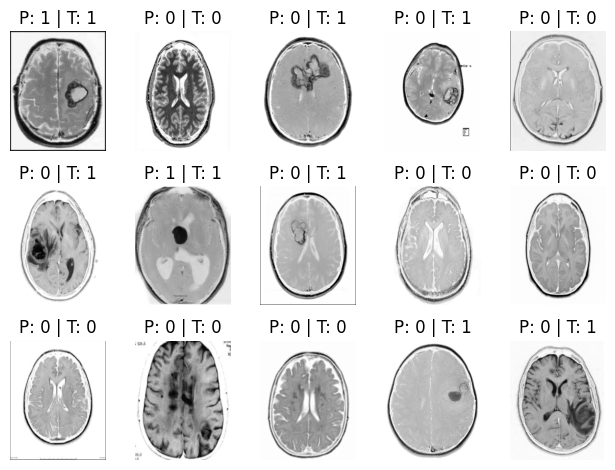

In [68]:
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import torchvision.transforms as transforms

class MyDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None, target_size=(300, 240)):
        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_name = df['image']
        self.y = df['label']
        self.transform = transform
        self.target_size = target_size

        # Define a transformation to resize images to the target size
        self.resize_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),  # Ensure all images are grayscale
            transforms.Resize(self.target_size),
        ])

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.img_name[index])
        img = Image.open(img_path).convert('L')  # Ensure all images are grayscale

        # Apply resize transformation
        img = self.resize_transform(img)

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]
        return img, label

    def __len__(self):
        return len(self.y)

# Data augmentation transformations for the training data
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(60),
    transforms.RandomResizedCrop((300, 240), scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()  # Convert the image to a tensor
])

# Transformations for the validation and test data (only resize and to tensor)
test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure all images are grayscale
    transforms.Resize((300, 240)),
    transforms.ToTensor()
])

# Create data loaders
train_dataset = MyDataset(csv_path="drive/MyDrive/brain_tumor_dataset/train_data.csv",
                          img_dir="drive/MyDrive/brain_tumor_dataset/train_data",
                          transform=train_transforms)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=16,
                          drop_last=True,
                          shuffle=True,
                          num_workers=0)

valid_dataset = MyDataset(csv_path="drive/MyDrive/brain_tumor_dataset/valid_data.csv",
                          img_dir="drive/MyDrive/brain_tumor_dataset/valid_data",
                          transform=test_transforms)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=16,
                          shuffle=False,
                          num_workers=0)

test_dataset = MyDataset(csv_path="drive/MyDrive/brain_tumor_dataset/test_data.csv",
                         img_dir="drive/MyDrive/brain_tumor_dataset/test_data",
                         transform=test_transforms)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=16,
                         shuffle=False,
                         num_workers=0)

torch.manual_seed(0)

# Print batch details
for images, labels in train_loader:
  print('Image batch dimensions:', images.shape)
  print('Image label dimensions:', labels.shape)
  print('Class labels of 10 Examples:', labels[:10])
  break

# Assuming the helper functions are correctly defined and imported
#from helper_evaluation import set_all_seeds, set_deterministic
#from helper_train import train_model
#from helper_plotting import plot_training_loss, plot_accuracy, show_examples
#from helper_dataset import get_dataloaders

RANDOM_SEED = 1
BATCH_SIZE = 16
NUM_EPOCHS = 25

train_loader, valid_loader, test_loader = get_dataloaders(batch_size=BATCH_SIZE,
                                                          train_transforms=train_transforms,
                                                          test_transforms=test_transforms)

for images, labels in train_loader:
  print('Image batch dimensions:', images.shape)
  print('Image label dimensions:', labels.shape)
  print('Class labels of 10 Examples:', labels[:10])
  break

# Set random seed and deterministic behavior
set_all_seeds(RANDOM_SEED)
set_deterministic()

# Define your model, optimizer, and device
# model = ...
# optimizer = ...
# device = ...

# Train the model
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=None
)

# Plotting results (assuming plotting functions are defined)
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)
plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
show_examples(model, test_loader)